In [1]:
% matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import math

from IPython import display

import os
import time
import copy
import math

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.optim import lr_scheduler
from torch.autograd import Variable
from torch.nn.parameter import Parameter
from torch.utils.data import Dataset, DataLoader


np.random.seed(11)

num_neuro_1 = 10
num_neuro_2 = 7
num_neuro_3 = 3

RES_DIR = './PUNKT_4_15/'
DATA_DIR = './CCPP/'
HOME_DIR = './'
use_gpu = False

In [2]:
def save_wts(net, save_dir, before=False, is_pytorch=False):
    if is_pytorch:
        net_wts = copy.deepcopy(net.state_dict())
        if before:
            torch.save(net_wts, save_dir+'params_before')
        else:
            torch.save(net_wts, save_dir+'params')
    else:
        w1 = pd.DataFrame((net.lin1.W).data.numpy())
        b1 = pd.DataFrame((net.lin1.b).data.numpy())
        w2 = pd.DataFrame((net.lin2.W).data.numpy())
        b2 = pd.DataFrame((net.lin2.b).data.numpy())
        w3 = pd.DataFrame((net.lin3.W).data.numpy())
        b3 = pd.DataFrame((net.lin3.b).data.numpy())
        w4 = pd.DataFrame((net.lin4.W).data.numpy())
        b4 = pd.DataFrame((net.lin4.b).data.numpy())
        if before:
            w1.to_csv(save_dir+'w1_before.csv', index=False)
            w2.to_csv(save_dir+'w2_before.csv', index=False)
            w3.to_csv(save_dir+'w3_before.csv', index=False)
            w4.to_csv(save_dir+'w4_before.csv', index=False)
            b1.to_csv(save_dir+'b1_before.csv', index=False)
            b2.to_csv(save_dir+'b2_before.csv', index=False)
            b3.to_csv(save_dir+'b3_before.csv', index=False)
            b4.to_csv(save_dir+'b4_before.csv', index=False)
        else:
            w1.to_csv(save_dir+'w1_.csv', index=False)
            w2.to_csv(save_dir+'w2_.csv', index=False)
            w3.to_csv(save_dir+'w3_.csv', index=False)
            w4.to_csv(save_dir+'w4_.csv', index=False)
            b1.to_csv(save_dir+'b1_.csv', index=False)
            b2.to_csv(save_dir+'b2_.csv', index=False)
            b3.to_csv(save_dir+'b3_.csv', index=False)
            b4.to_csv(save_dir+'b4_.csv', index=False)
            

In [3]:
# data - tensor
def search_crit(data, crit):
    max_value_in_column, max_line_ids, max_value, max_column_id = None, None, None, None
    
    if crit=='max':
        max_value_in_column, max_line_ids = torch.max(data,0)
        max_value , max_column_id = torch.max(max_value_in_column, 0)
    elif crit=='mean':
        max_value_in_column, max_line_ids = torch.median(data,0)
        max_value , max_column_id = torch.median(max_value_in_column, 0)
    else:
        max_value_in_column, max_line_ids = torch.min(data,0)
        max_value , max_column_id = torch.min(max_value_in_column, 0)
    
    return max_line_ids[max_column_id[0]],max_column_id[0], max_value[0]


def search_lr_i(net, opt_state, crit):
    left_board, right_board, layer,value = 0, 0, 0, 0.0

    buf = [[],[],[],[]]
    idx=1
    for m in net.modules():
        if isinstance(m, nn.Linear):
            a, b, m = search_crit(opt_state[m.weight]['square_avg'], crit)
            buf[0].append(a)
            buf[1].append(b)
            buf[2].append(m)
            buf[3].append(idx)
            idx += 1
    print(buf)
    if crit=='max':
        left_board = buf[0][np.argmax(buf[2])]
        right_board = buf[1][np.argmax(buf[2])]
        value = buf[2][np.argmax(buf[2])]
        layer = buf[3][np.argmax(buf[2])]
    elif crit=='min':
        left_board = buf[0][np.argmin(buf[2])]
        right_board = buf[1][np.argmin(buf[2])]
        value = buf[2][np.argmin(buf[2])]
        layer = buf[3][np.argmin(buf[2])]
    else:
        left_board = buf[0][np.argwhere(buf[2][i]==np.median(buf[2]) for i in range(len(buf[2])))[0,0]]
        right_board = buf[1][np.argwhere(buf[2][i]==np.median(buf[2]) for i in range(len(buf[2])))[0,0]]
        value = buf[2][np.argwhere(buf[2][i]==np.median(buf[2]) for i in range(len(buf[2])))[0,0]]
        layer = buf[3][np.argwhere(buf[2][i]==np.median(buf[2]) for i in range(len(buf[2])))[0,0]]
        
    return layer, left_board, right_board


def define_module(net, layer):
    if layer==1:
        return net.fc1
    elif layer==2:
        return net.fc2
    elif layer==3:
        return net.fc3
    else:
        return net.fc4

In [4]:
def get_all(module):
    w = module.weight.data.numpy()
    b = module.bias.data.numpy().reshape((module.bias.data.size(0), 1))
    a = np.hstack((w, b))
    
    return a

In [5]:
from IPython import display
from sklearn.preprocessing import normalize
# обучение модели; dataloader разделен на обуч. и валид. выборки
def train_model(model, name, dataloaders, dataset_sizes, criterion, optimizer, scheduler, num_epochs=25, need_wts=False):
    since = time.time()
    fig = plt.figure()
    
    err_epoh = []
    valid_err_epoh = []
    test_err_epoh = []
    lr_list = []
    wts_list = []
        
    a_max, b_max, l_max, a_mean, b_mean, l_mean, a_min, b_min, l_min = 0, 0, 0, 0, 0, 0, 0, 0, 0
    m_max, m_mean, m_min = None, None, None

    for epoch in range(num_epochs):
        
        if (epoch%10 == 9):
            plt.grid(True)
            plt.plot(err_epoh, color='r')
            plt.plot(valid_err_epoh, color='b')
            plt.plot(test_err_epoh, color='g')
            
            display.clear_output(wait=True)
            display.display(plt.gcf())
            
            print('Epoch {}/{}'.format(epoch, num_epochs - 1))
            print("train: ", err_epoh[epoch-1])
            print("valid: ", valid_err_epoh[epoch-1])
            print("test: ", test_err_epoh[epoch-1])
            print('-' * 10)          
        
        if epoch==1:
            l_max, a_max, b_max = search_lr_i(model, optimizer.state, crit='min')
            l_mean, a_mean, b_mean = search_lr_i(model, optimizer.state, crit='mean')
            l_min, a_min, b_min = search_lr_i(model, optimizer.state, crit='max')
        
        # Each epoch has a training and validation phase
        for phase in ['train', 'val', 'test']:
            if phase == 'train':
                scheduler.step()
                model.train(True)  # Set model to training mode
            else:
                model.train(False)  # Set model to evaluate mode

            running_loss = 0.0                
            
            # Iterate over data.
            data = datasets[phase].data
                # get the inputs
            inputs, labels = torch.FloatTensor(data[:, 0:IN_SIZE]), torch.FloatTensor(data[:, IN_SIZE]).unsqueeze(1)

                # wrap them in Variable
            if use_gpu:
                inputs = Variable(inputs.cuda(CUDA_DEVICE))
                labels = Variable(labels.cuda(CUDA_DEVICE))
            else:
                inputs, labels = Variable(inputs), Variable(labels)

                # zero the parameter gradients
            optimizer.zero_grad()

                # forward
            outputs = model(inputs)
            #print(outputs.size())
            _, preds = torch.max(outputs.data, 1)
            loss = criterion(outputs, labels)

            wts = []
            for m in model.modules():
                if isinstance(m, nn.Linear):
                    w = get_all(m)
                    w = normalize(w, norm='l2')
                    wts.append(w)
            l2_norm = []
            for i in range(len(wts)):
                l2_norm.append(np.sum(wts[i]))        
            l2_norm = sum(l2_norm)     
            
            new_wts = []
            for m in model.modules():
                if isinstance(m, nn.Linear):
                    w = get_all(m)
                    w = normalize(w, norm='l1')
                    new_wts.append(w)
            l1_norm =[]
            for i in range(len(new_wts)):
                l1_norm.append(np.sum(new_wts[i]))
            l1_norm = sum(l1_norm)
            
            if phase == 'train':
                loss.backward()
                
                optimizer.step()
                if nomer==1:
                    loss += reg*l1_norm
                
                # statistics
            running_loss += loss.data[0] * inputs.size(0)

            epoch_loss = running_loss / dataset_sizes[phase]
            
            # для графиков E(t)
            if phase == 'train':
                err_epoh.append(epoch_loss)
                
                # для графиков w(t)
                if need_wts:
                    wts_list.append(l2_norm)
                    lr_list.append(l1_norm)
                    #print(len(wts_list))
            elif phase == 'val':
                valid_err_epoh.append(epoch_loss)
            else:
                test_err_epoh.append(epoch_loss)
                
            
            
            if (epoch%500 == 1):
                print('{} Loss: {:.4f}'.format(phase, epoch_loss))

        #print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
    plt.title(name)
    plt.savefig(name)
    return model, wts_list, lr_list, err_epoh, valid_err_epoh, test_err_epoh

In [6]:
learn_data = pd.read_csv(HOME_DIR+'split_data/train_set.csv').values
print('\n', learn_data.shape)

BATCH_SIZE = len(learn_data)
IN_SIZE = learn_data.shape[1]-1


 (5622, 5)


In [7]:
class CCPPDataset(Dataset):
    def __init__(self, data):
        self.data = data
        
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        return self.data[idx]
    
datasets = {x: CCPPDataset(pd.read_csv(HOME_DIR+'split_data/'+x+'_set.csv').values)
                  for x in ['train', 'val', 'test']}
dataloaders = {x: torch.utils.data.DataLoader(datasets[x], batch_size=BATCH_SIZE,
                                             shuffle=True, num_workers=4)
              for x in ['train', 'val', 'test']}
dataset_sizes = {x: len(datasets[x]) for x in ['train', 'val', 'test']}

In [8]:
class MainPyNet(nn.Module):
    
    def __init__(self, in_size, out_size):
        super(MainPyNet, self).__init__()
        
        self.fc1 = nn.Linear(in_size, num_neuro_1)
        self.fc2 = nn.Linear(num_neuro_1, num_neuro_2)
        self.fc3 = nn.Linear(num_neuro_2, num_neuro_3)
        self.fc4 = nn.Linear(num_neuro_3, out_size)
        
        #for m in self.modules():
          #  m.weight.data.normal_(0, 1)
          #  m.bias.data.fill_(1)
        
    def forward(self, x):
        x = F.tanh(self.fc1(x))
        x = F.tanh(self.fc2(x))
        x = F.tanh(self.fc3(x))
        x = F.tanh(self.fc4(x))
        return x

In [9]:
# начальная точка длля всех моделей pytorch
net = MainPyNet(IN_SIZE, 1)
print(net)


num_epoch = 100
lr = 1e-3
reg_list = [x/100 for x in range(10, 510, 10)]
nomer = 1
name = 'L'+str(nomer)+'_'
#smooth_list = [0, 0.5, 0.9, 0.99]
p = 0.99

errs_list = {'param': [], 'train': [], 'val': [], 'test': []}
wts_list = []
lr_list = []

MainPyNet(
  (fc1): Linear(in_features=4, out_features=10, bias=True)
  (fc2): Linear(in_features=10, out_features=7, bias=True)
  (fc3): Linear(in_features=7, out_features=3, bias=True)
  (fc4): Linear(in_features=3, out_features=1, bias=True)
)


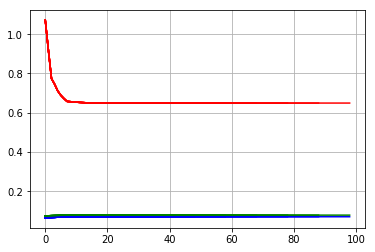

Epoch 99/99
train:  0.649384081363678
valid:  0.07047916203737259
test:  0.07875204086303711
----------
Training complete in 0m 2s
train: 0.649384081363678
valid: 0.07047916203737259
test: 0.07875204086303711


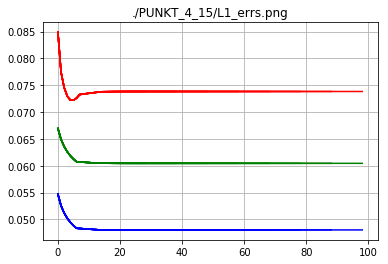

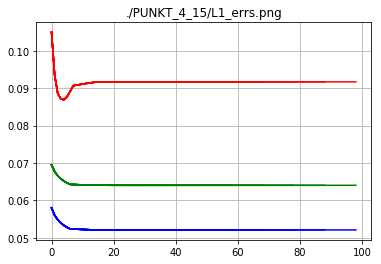

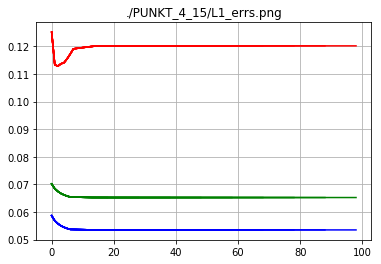

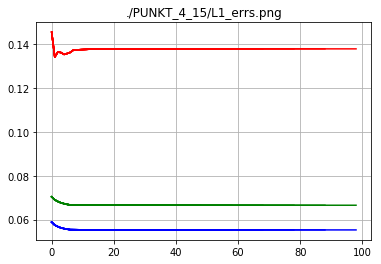

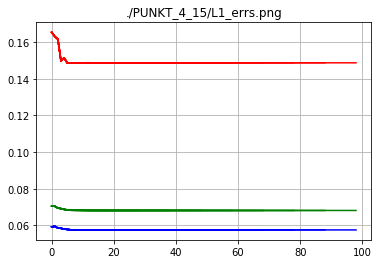

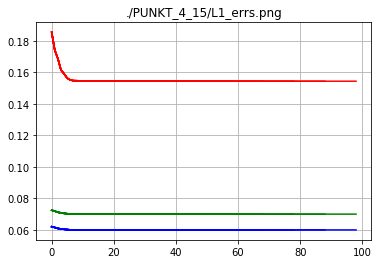

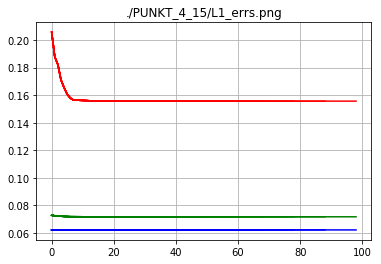

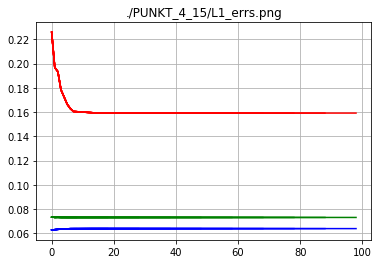

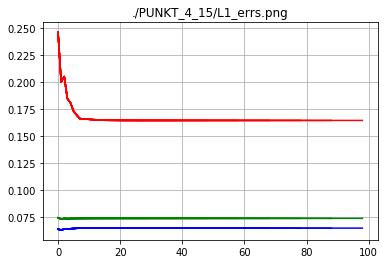

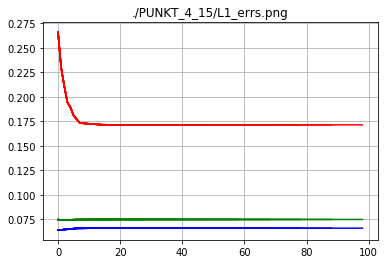

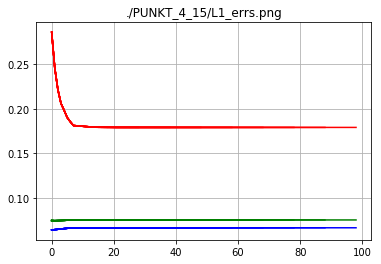

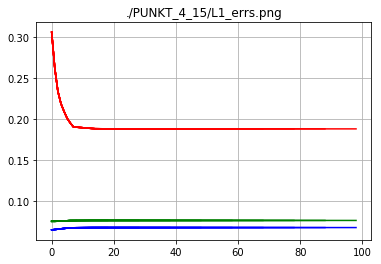

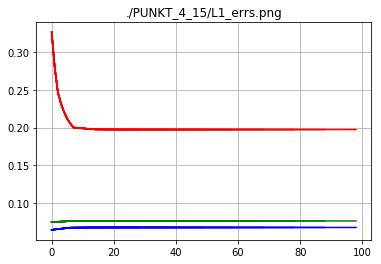

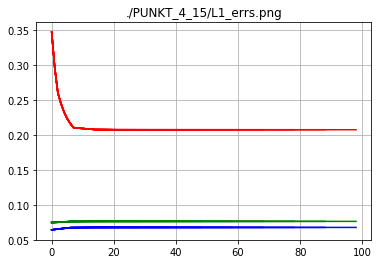

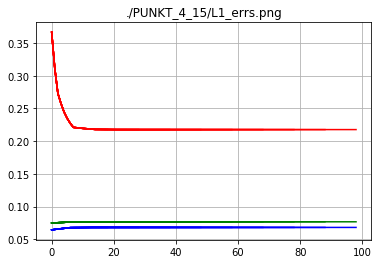

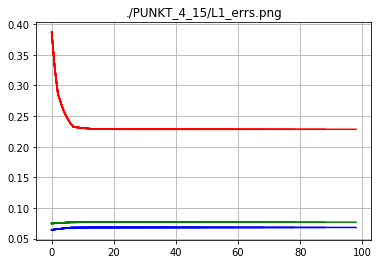

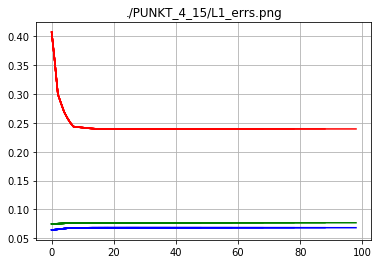

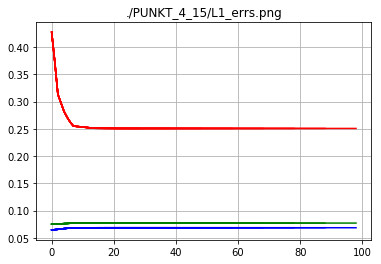

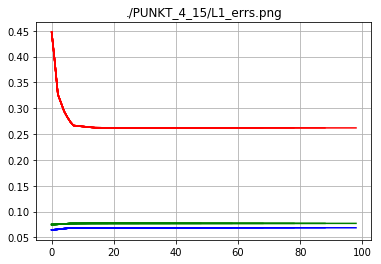

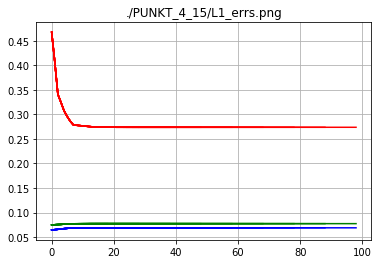

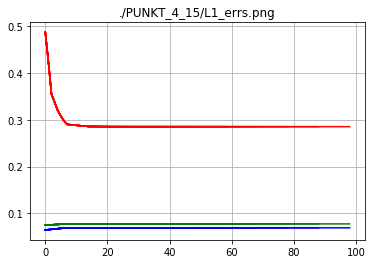

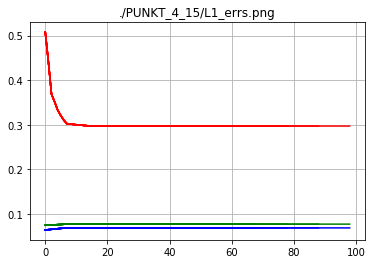

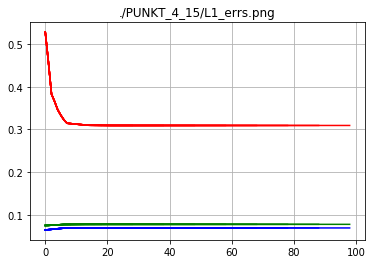

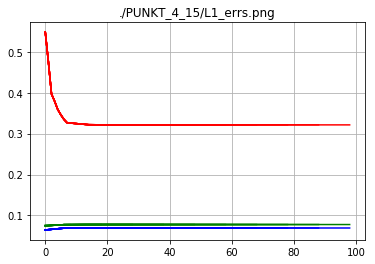

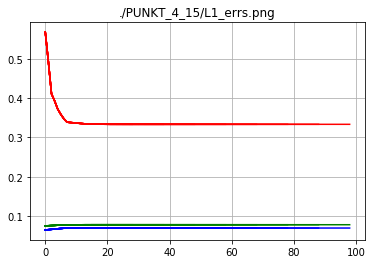

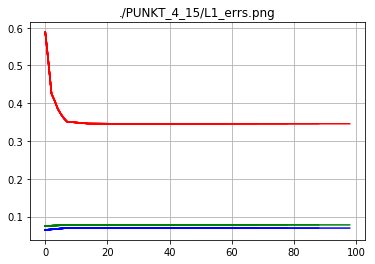

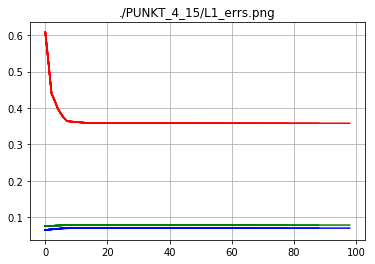

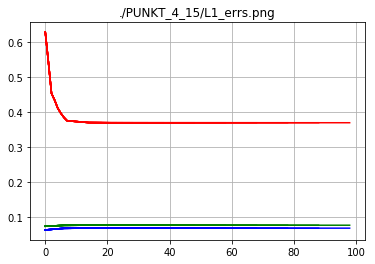

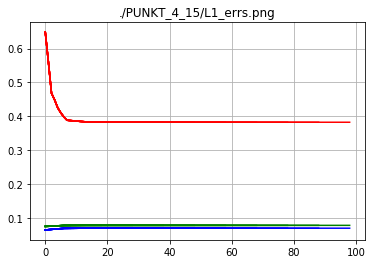

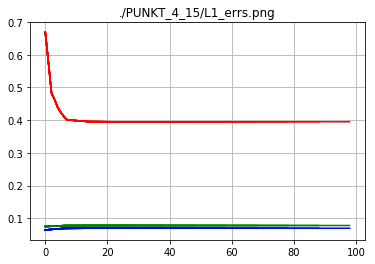

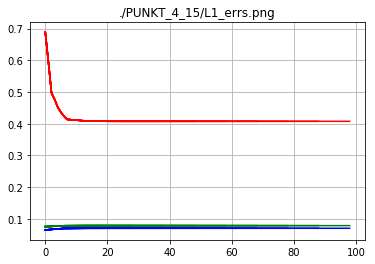

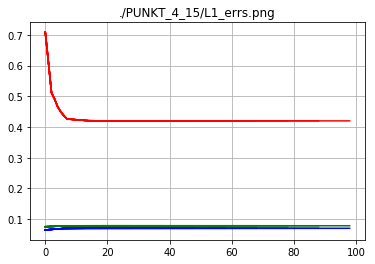

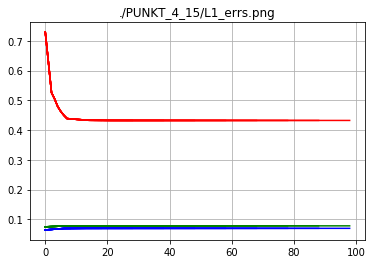

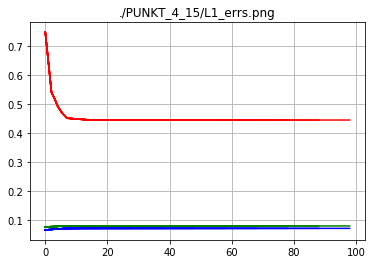

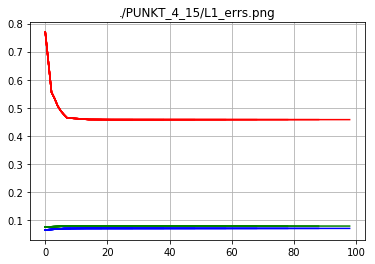

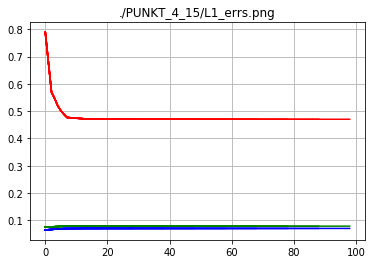

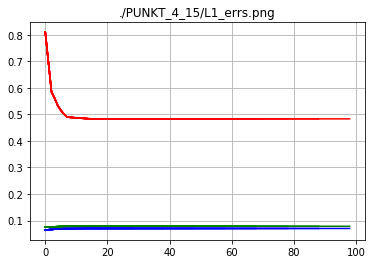

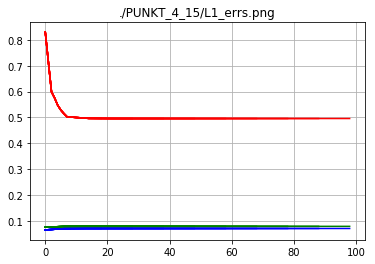

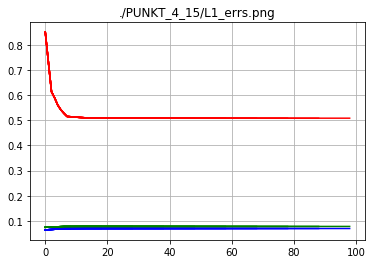

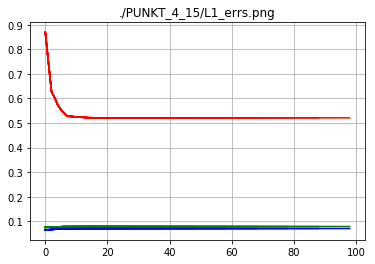

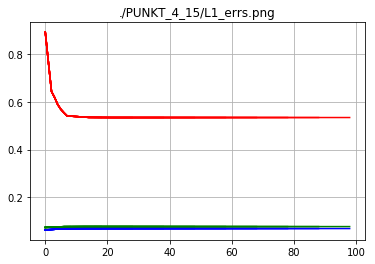

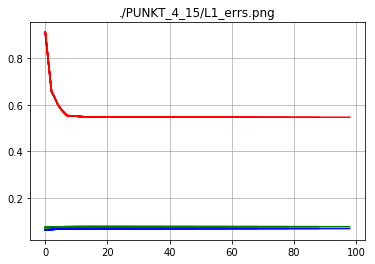

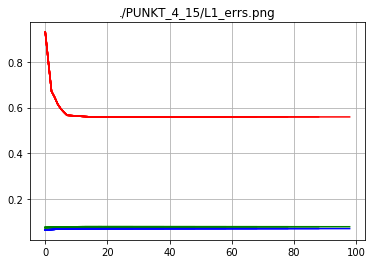

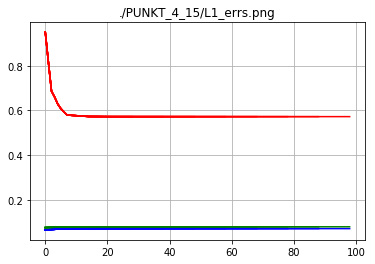

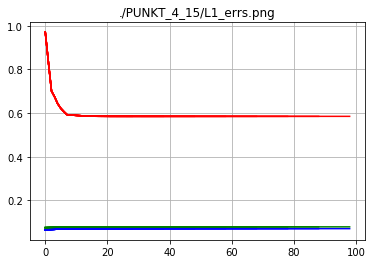

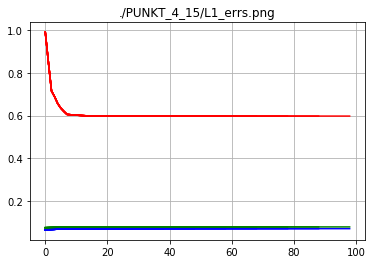

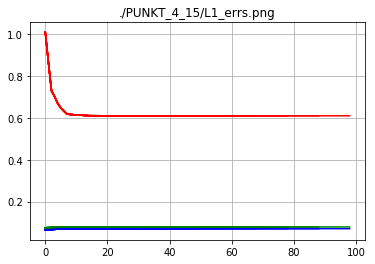

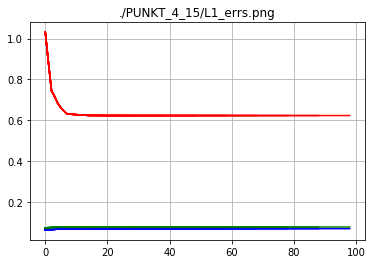

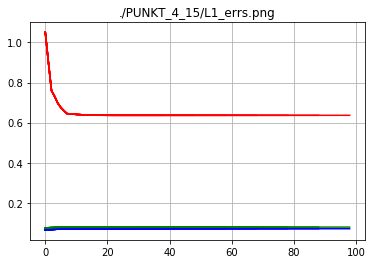

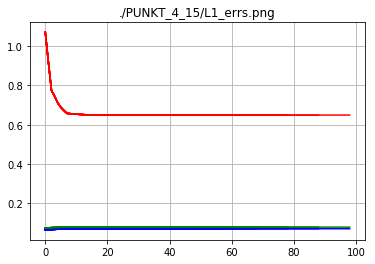

In [10]:
for reg in reg_list:
    print(p, ':')
    net.load_state_dict(torch.load(RES_DIR+'params_before'))
    
    criterion = nn.MSELoss()
    optimizer = optim.RMSprop(net.parameters(), lr=lr, alpha=p, weight_decay=reg)
    sheduler = lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)
    net, wts, lrs, er_list, val_er_list, test_er_list = train_model(net, name=RES_DIR+name+'errs.png',
            dataloaders=dataloaders, dataset_sizes=dataset_sizes,
            criterion=criterion, optimizer=optimizer, scheduler=sheduler,
                        num_epochs=num_epoch, need_wts=True)
    
    errs_list['param'].append(reg)
    errs_list['train'].append(er_list[-1])
    errs_list['val'].append(val_er_list[-1])
    errs_list['test'].append(test_er_list[-1])
    
    wts_list.append(wts)
    lr_list.append(lrs)
    
    print('train: {}\nvalid: {}\ntest: {}'.format(er_list[-1], val_er_list[-1], test_er_list[-1]))

In [11]:
df = pd.DataFrame(errs_list)
#df.to_csv(RES_DIR+'L'+str(nomer)+'_err_lists.csv', index=False)
df

,param,test,train,val
0,0.1,0.060441,0.073838,0.048024
1,0.2,0.064027,0.091725,0.052075
2,0.3,0.065254,0.120210,0.053521
3,0.4,0.066542,0.137702,0.055310
4,0.5,0.068131,0.148714,0.057516
5,0.6,0.069900,0.154390,0.059862
6,0.7,0.071785,0.155671,0.062265
7,0.8,0.073176,0.159165,0.063981
8,0.9,0.074157,0.164529,0.065155
9,1.0,0.074850,0.171438,0.065970


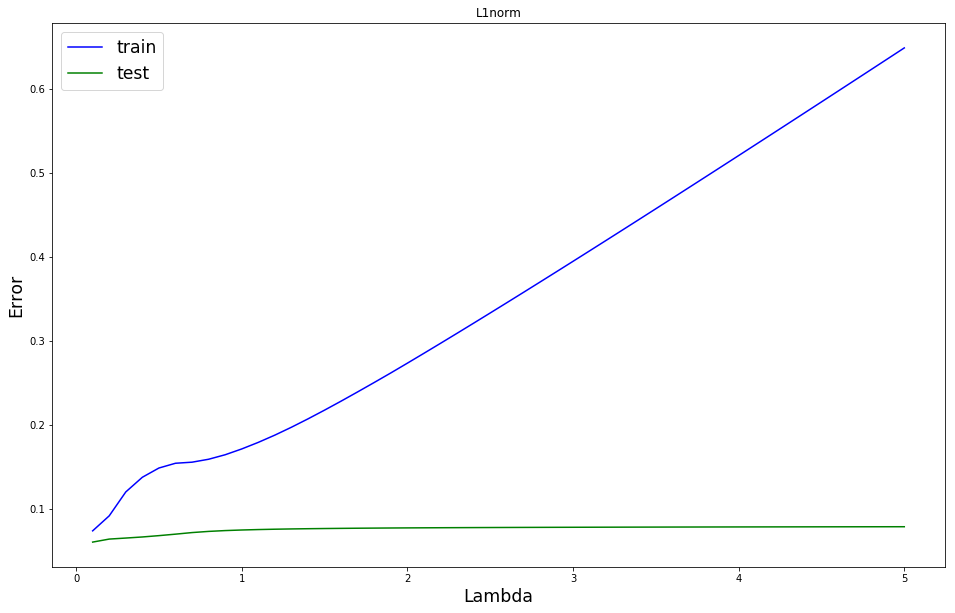

In [17]:
fig = plt.figure(figsize=(16, 10),)
plt.plot(df['param'], df['train'], color='b', label='train')
plt.plot(df['param'], df['test'], color='g', label='test')
plt.xlabel('Lambda', fontsize='xx-large')
plt.ylabel('Error', fontsize='xx-large')
plt.title('L'+str(nomer)+'norm', fontsize='xx-large')
plt.legend(loc=0, fontsize='xx-large')
plt.title('L'+str(nomer)+'norm')
#plt.show()
plt.savefig(RES_DIR+'4_15a_L'+str(nomer)+'.png')

In [13]:
len(wts_list)

50

In [14]:
#del wts[0:8]
wts_list_new = []
for i in range(len(wts_list)):
    wts_list_new.append(np.sum(wts_list[i])/len(wts_list[i]))
    
lrs_list_new = []
for i in range(len(lr_list)):
    lrs_list_new.append(np.sum(lr_list[i])/len(lr_list[i]))

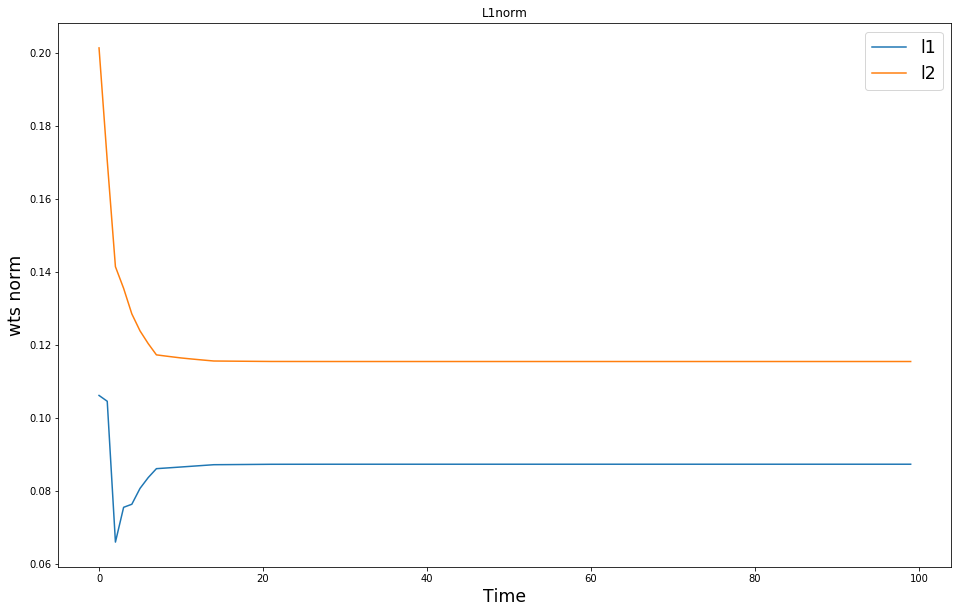

In [18]:
fig = plt.figure(figsize=(16, 10), clear=True)
idx_list = [x for x in range(num_epoch)]
plt.plot(idx_list, wts, label='l1')
plt.plot(idx_list, lrs, label='l2')
plt.xlabel('Time', fontsize='xx-large')
plt.ylabel('wts norm', fontsize='xx-large')
plt.title('L'+str(nomer)+'norm', fontsize='xx-large')
plt.legend(loc=0, fontsize='xx-large')
plt.title('L'+str(nomer)+'norm')
#plt.show()
plt.savefig(RES_DIR+'4_15b_L'+str(nomer)+'.png')

In [10]:
df = pd.DataFrame({x: errs_list[x] for x in errs_list.keys()})
df.to_csv(HOME_DIR+'RMS/'+'err_lists.csv')

df = pd.DataFrame({x: wts_list[x] for x in smooth_list})
df.to_csv(HOME_DIR+'RMS/'+'wts_lists.csv')

df = pd.DataFrame({x: lr_list[x] for x in smooth_list})
df.to_csv(HOME_DIR+'RMS/'+'lrs_lists.csv')

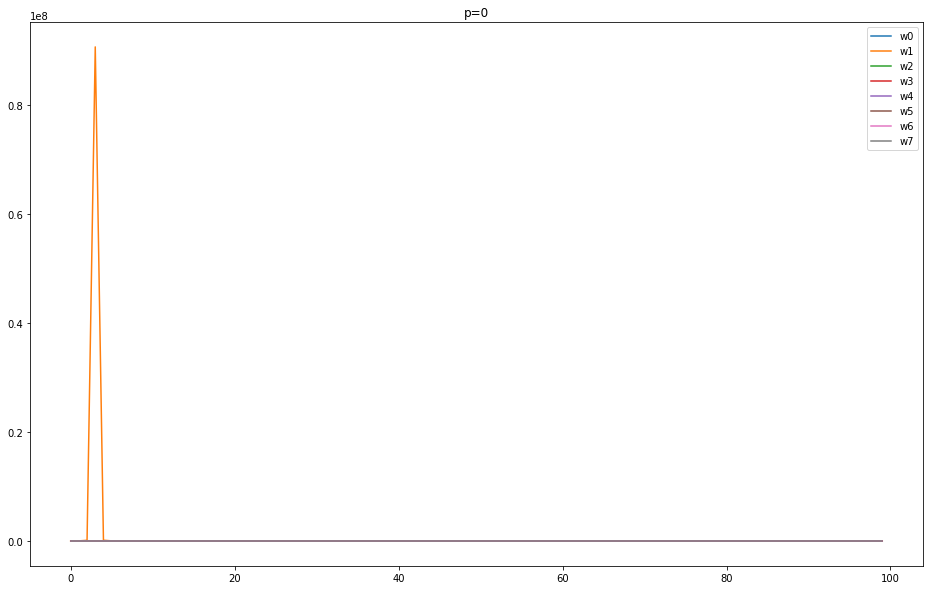

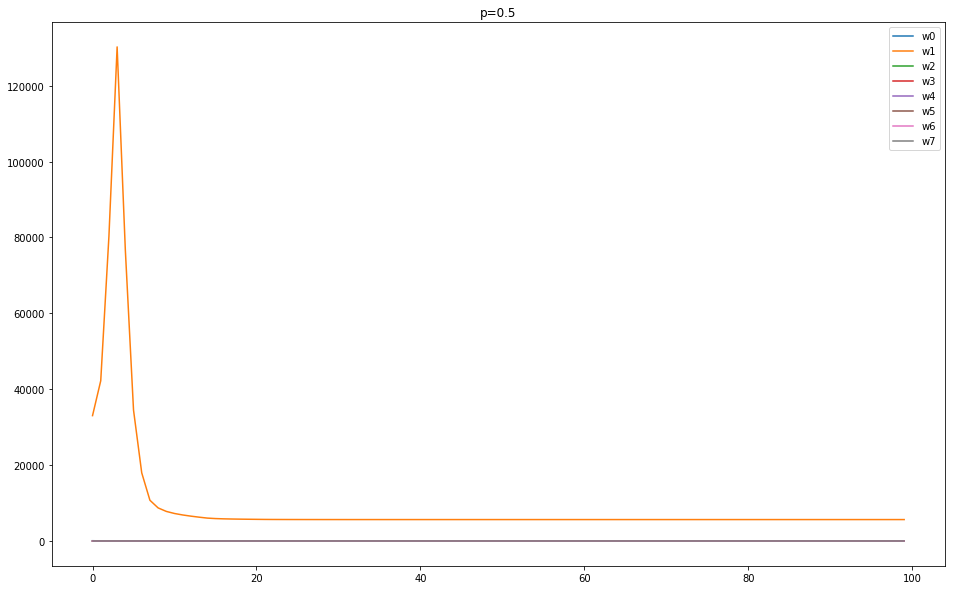

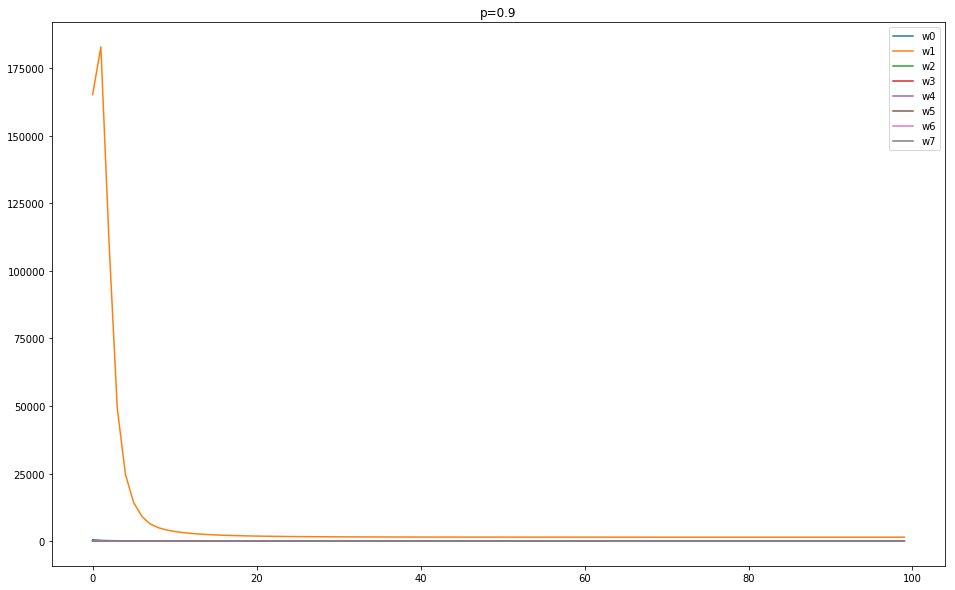

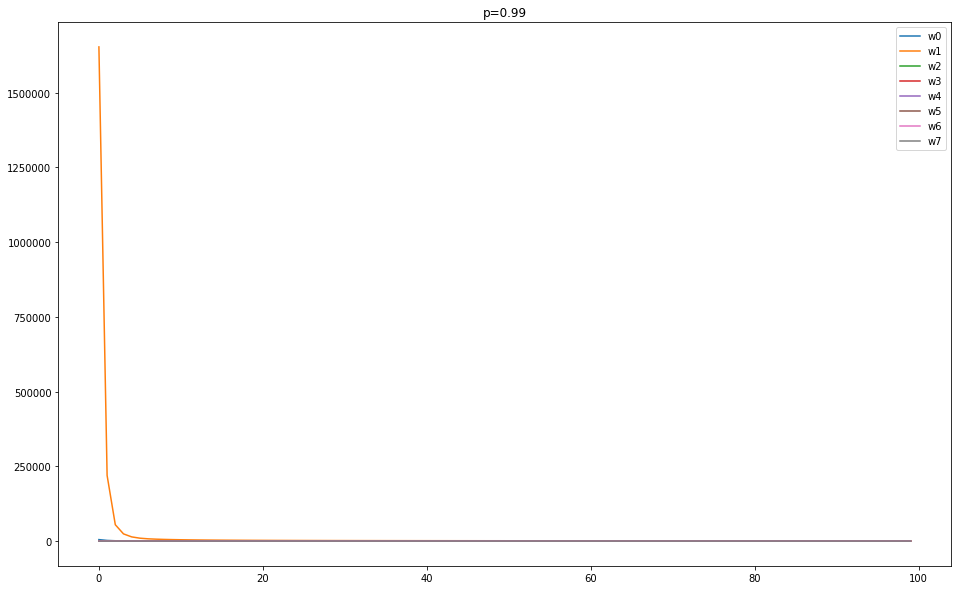

In [11]:
for i in wts_list.keys():
    fig = plt.figure(figsize=(16, 10), clear=True)
    idx=0
    
    for j in range(len(wts_list[i])):
        plt.plot(wts_list[i][j], label = 'w'+str(idx))
        idx+=1

    plt.legend()
    plt.title('p='+str(i))
    #plt.show()
    plt.savefig(HOME_DIR+'RMS/'+str(int(1000*i))+'wts.png', bbox_inches='tight')

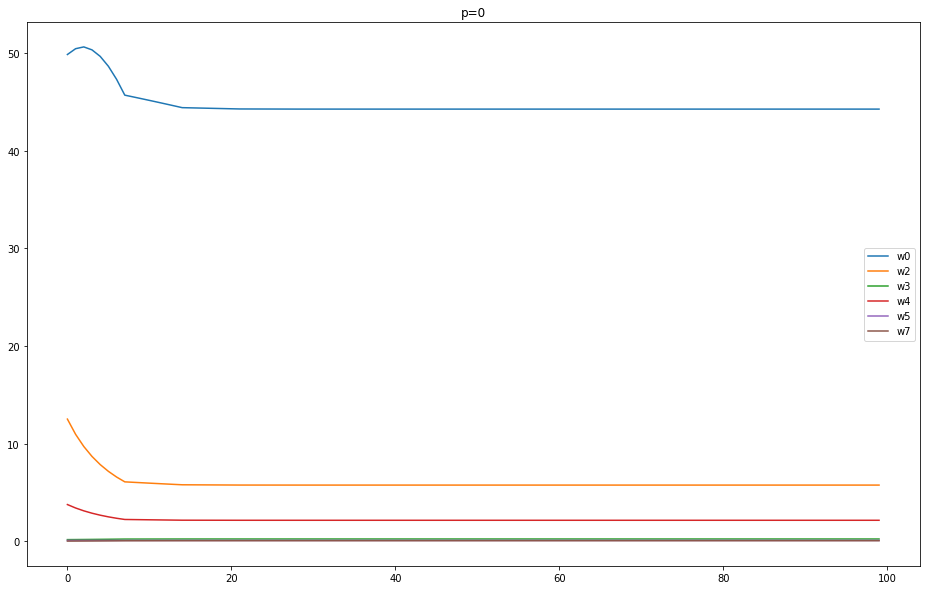

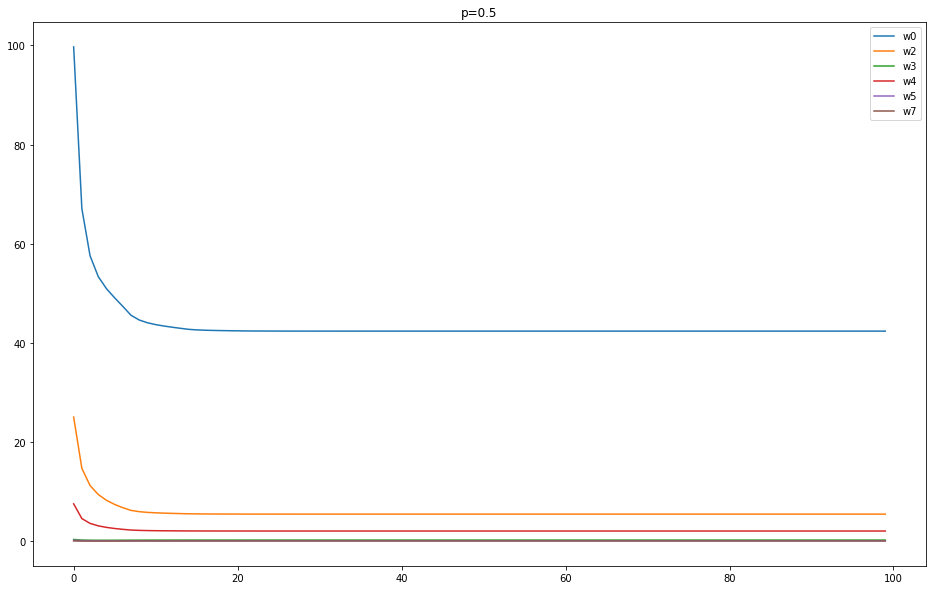

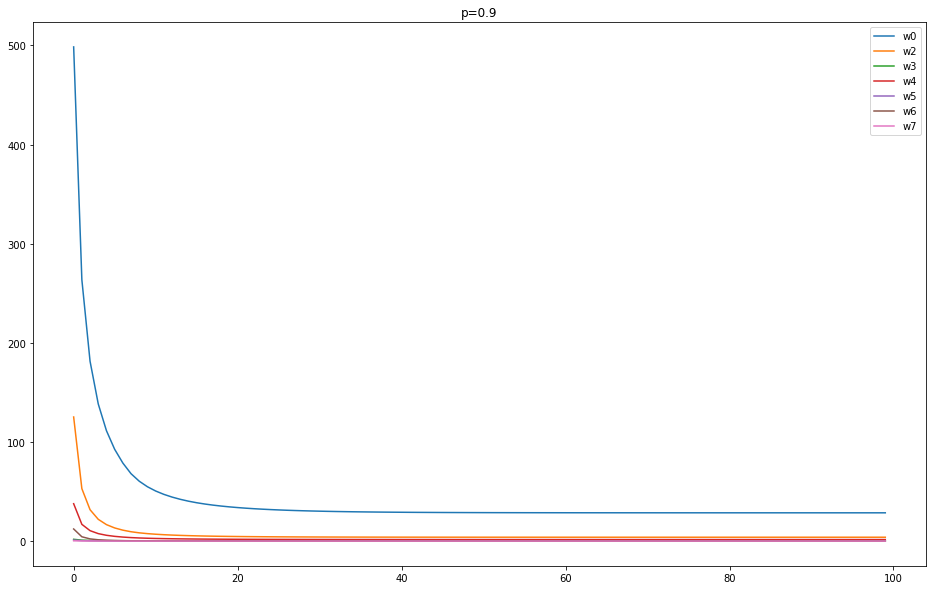

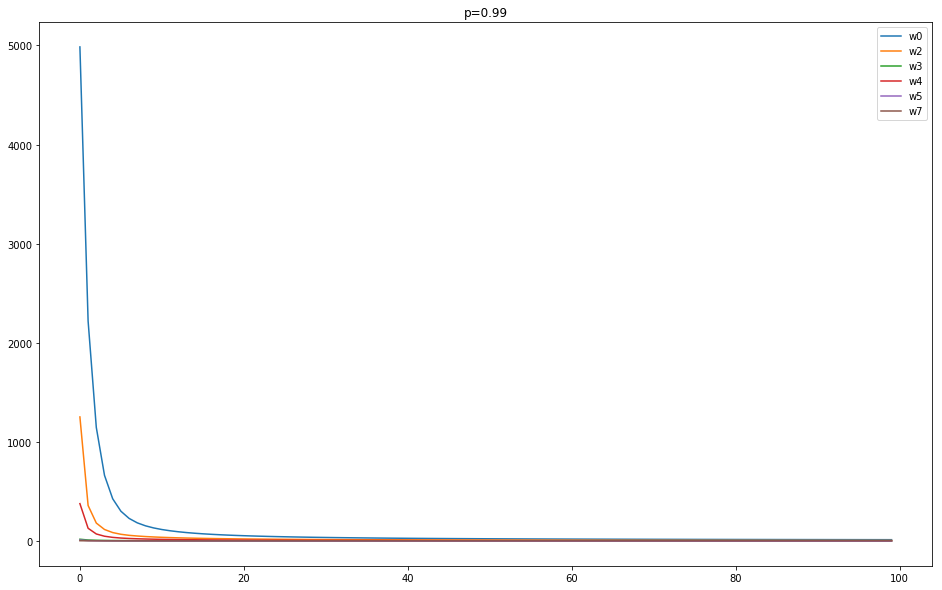

In [12]:
idx_list = {0: [0, 2, 3, 4, 5, 7],
            0.5: [0, 2, 3, 4, 5, 7], 0.9: [0, 2, 3, 4, 5, 6, 7],
            0.99: [0, 2, 3, 4, 5, 7]}

for i in wts_list.keys():
    fig = plt.figure(figsize=(16, 10), clear=True)
    k=0
    for j in idx_list[i]:
        plt.plot(wts_list[i][j], label = 'w'+str(idx_list[i][k]))
        k+=1

    plt.legend()
    plt.title('p='+str(i))
    #plt.show()
    plt.savefig(HOME_DIR+'RMS/'+str(int(1000*i))+'wts_1.png', bbox_inches='tight')

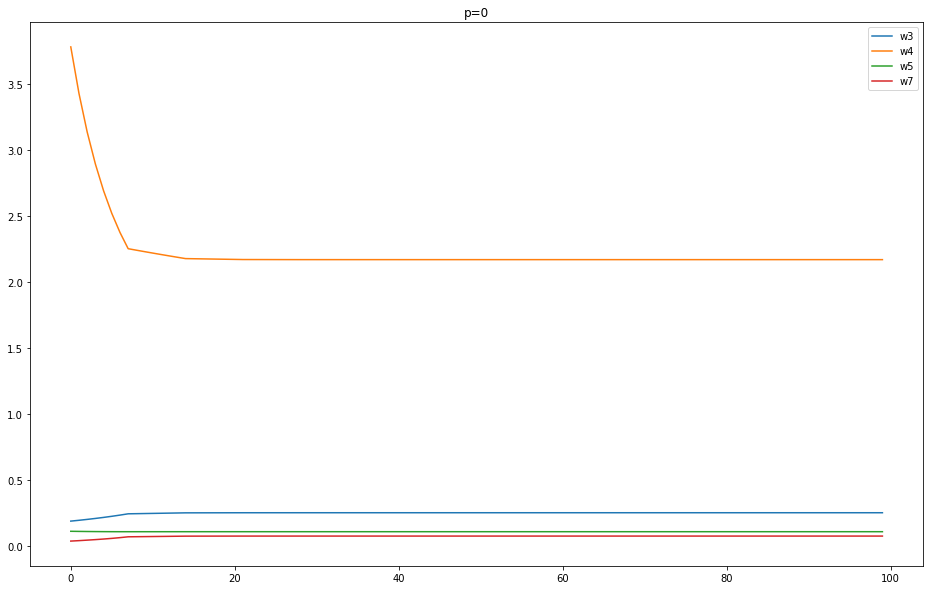

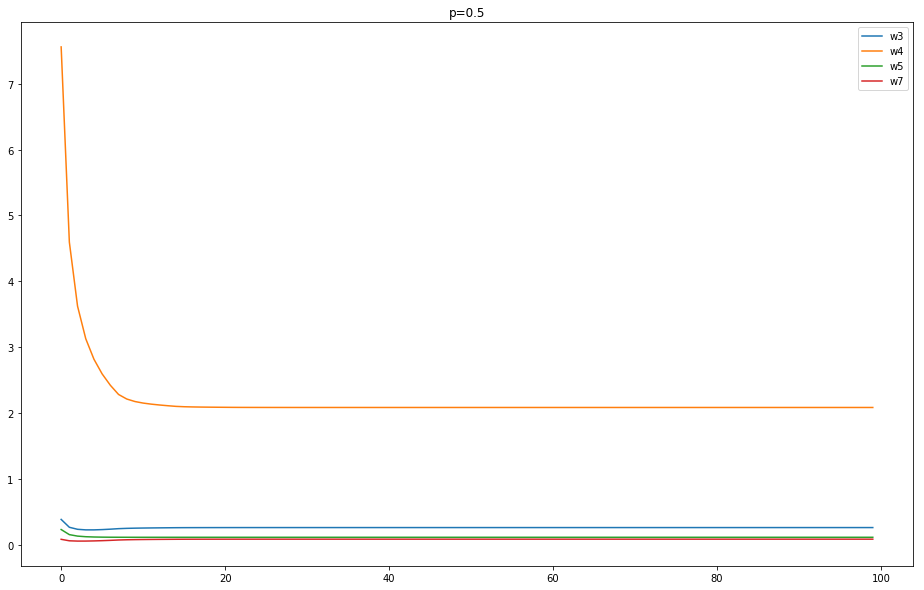

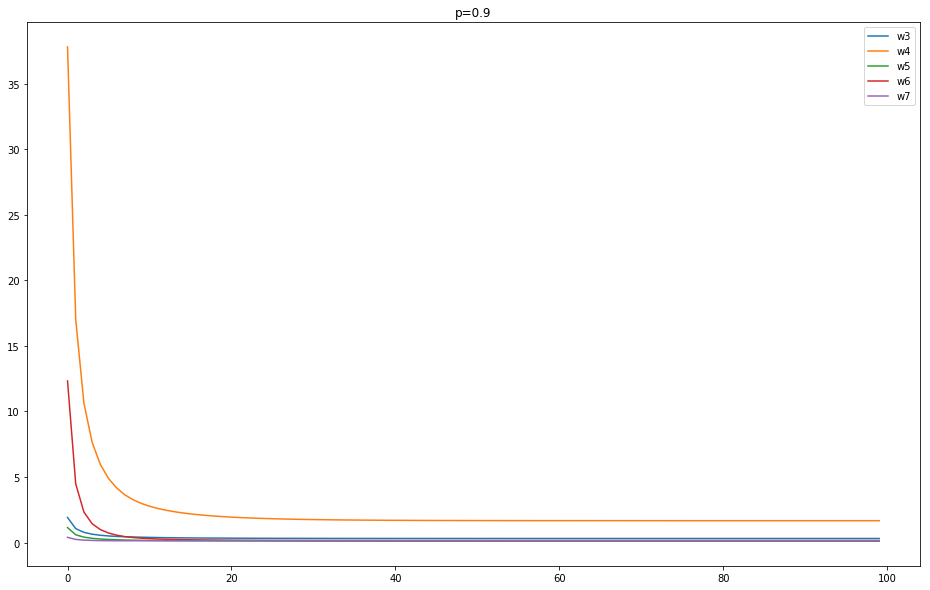

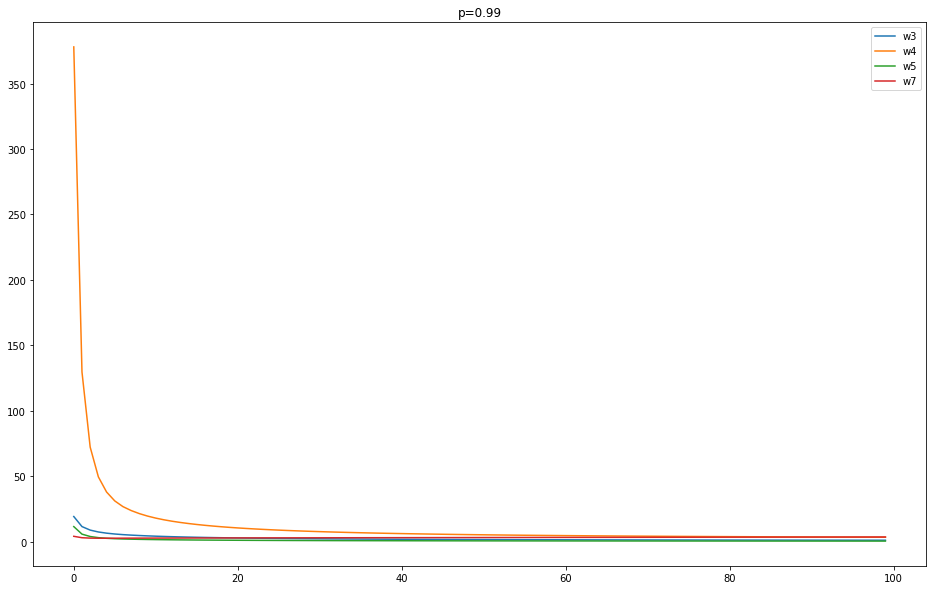

In [13]:
idx_list = {0: [3, 4, 5, 7],
            0.5: [3, 4, 5, 7], 0.9: [3, 4, 5, 6, 7],
            0.99: [3, 4, 5, 7]}

for i in wts_list.keys():
    fig = plt.figure(figsize=(16, 10), clear=True)
    k=0
    for j in idx_list[i]:
        plt.plot(wts_list[i][j], label = 'w'+str(idx_list[i][k]))
        k+=1

    plt.legend()
    plt.title('p='+str(i))
    #plt.show()
    plt.savefig(HOME_DIR+'RMS/'+str(int(1000*i))+'wts_2.png', bbox_inches='tight')

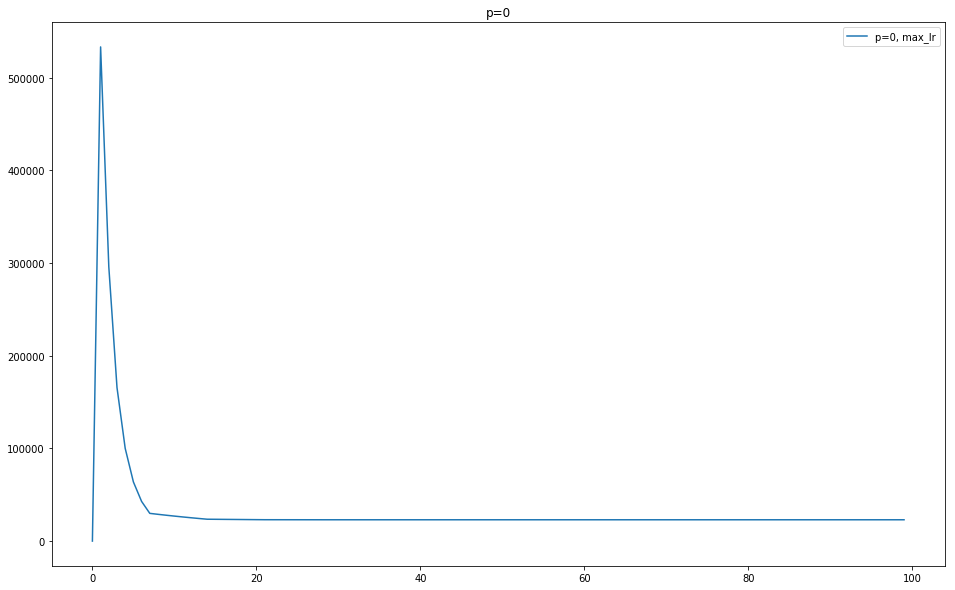

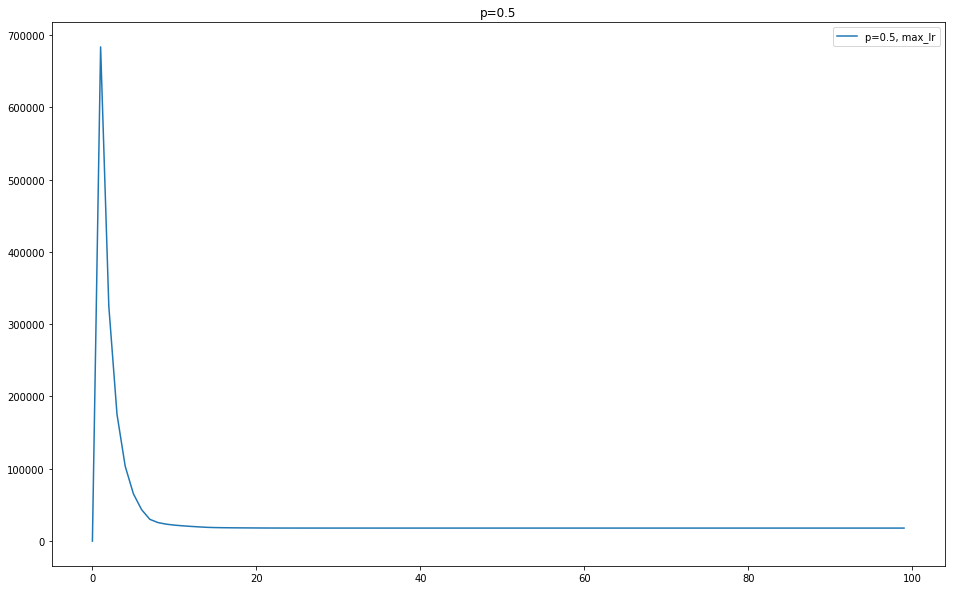

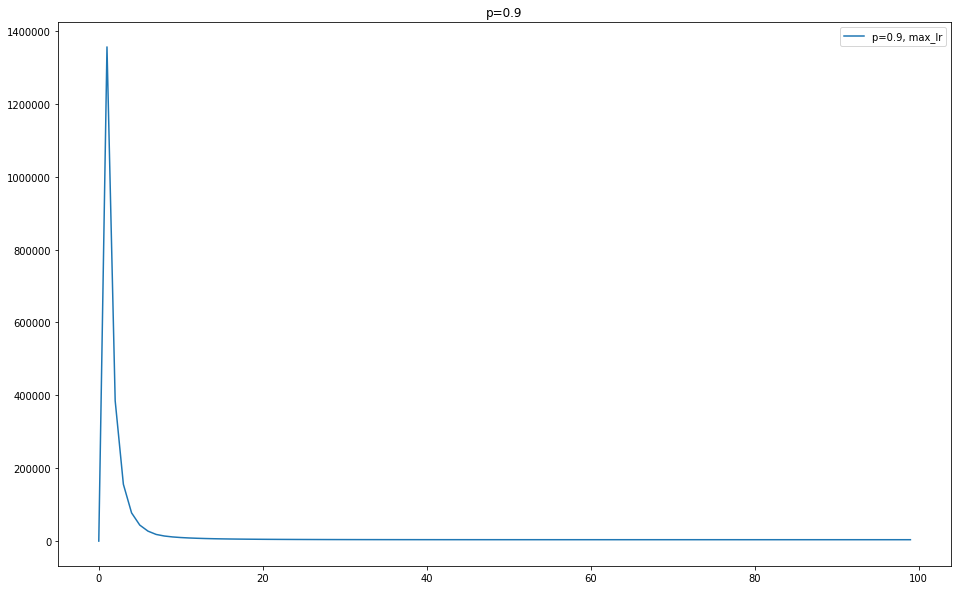

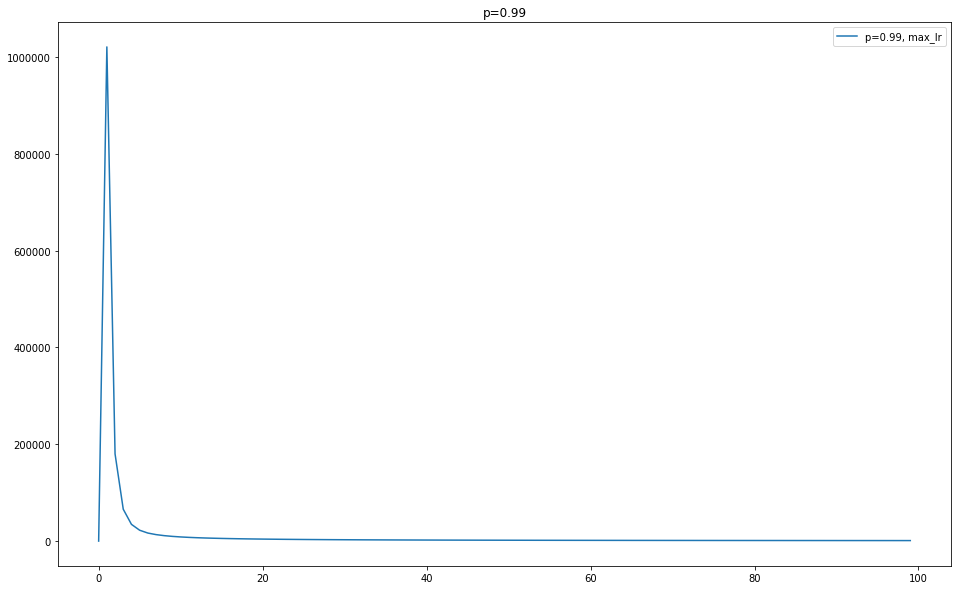

In [14]:
for i in lr_list.keys():
    fig = plt.figure(figsize=(16, 10), clear=True)
    
    for j in ['max']:
        plt.plot(lr_list[i][j], label = 'p='+str(i)+', '+j+'_lr')

    plt.legend()
    plt.title('p='+str(i))
    #plt.show()
    plt.savefig(HOME_DIR+'RMS/'+str(int(1000*i))+'lrs.png', bbox_inches='tight')

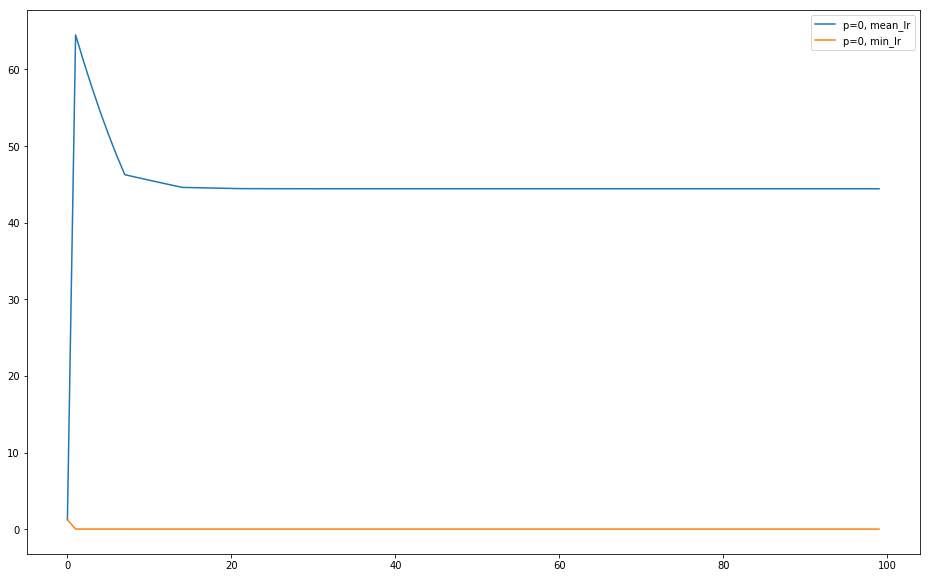

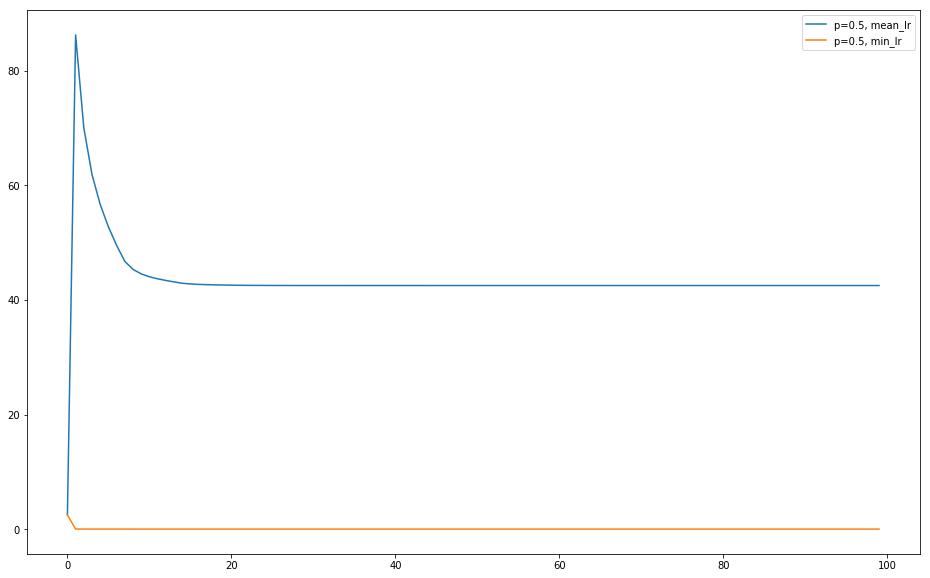

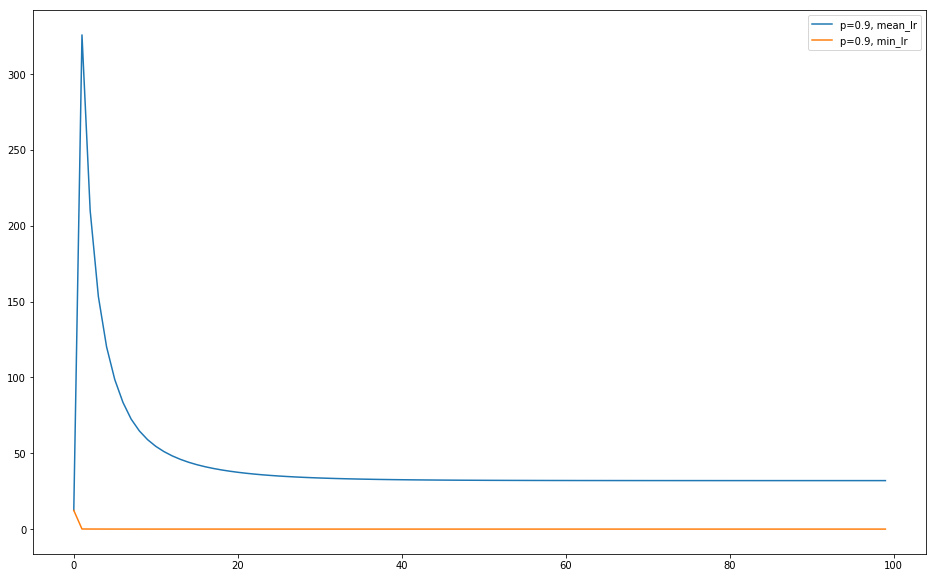

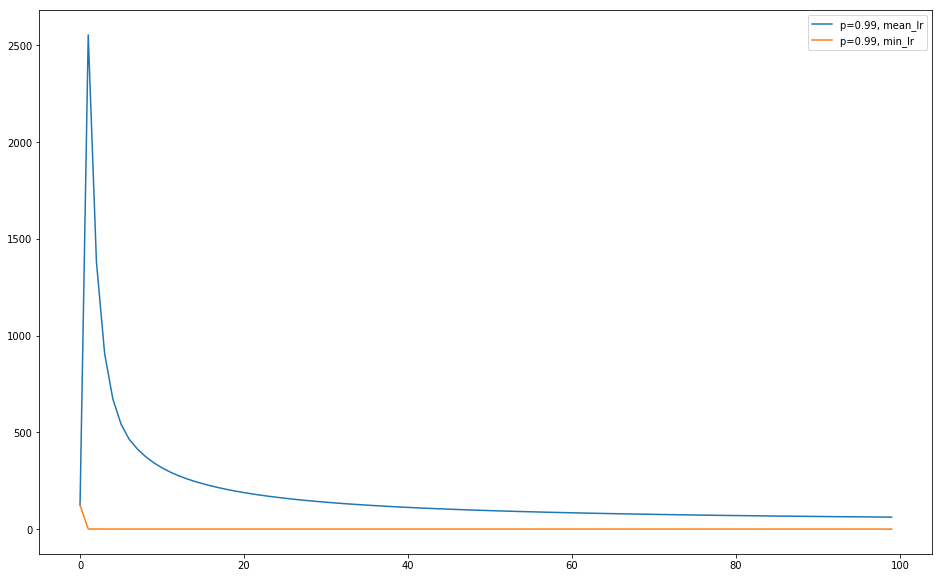

In [15]:
for i in lr_list.keys():
    fig = plt.figure(figsize=(16, 10), clear=True)
    
    for j in ['mean', 'min']:
        plt.plot(lr_list[i][j], label = 'p='+str(i)+', '+j+'_lr')

    plt.legend()
    #plt.show()
    plt.savefig(HOME_DIR+'RMS/'+str(int(1000*i))+'lrs_1.png', bbox_inches='tight')

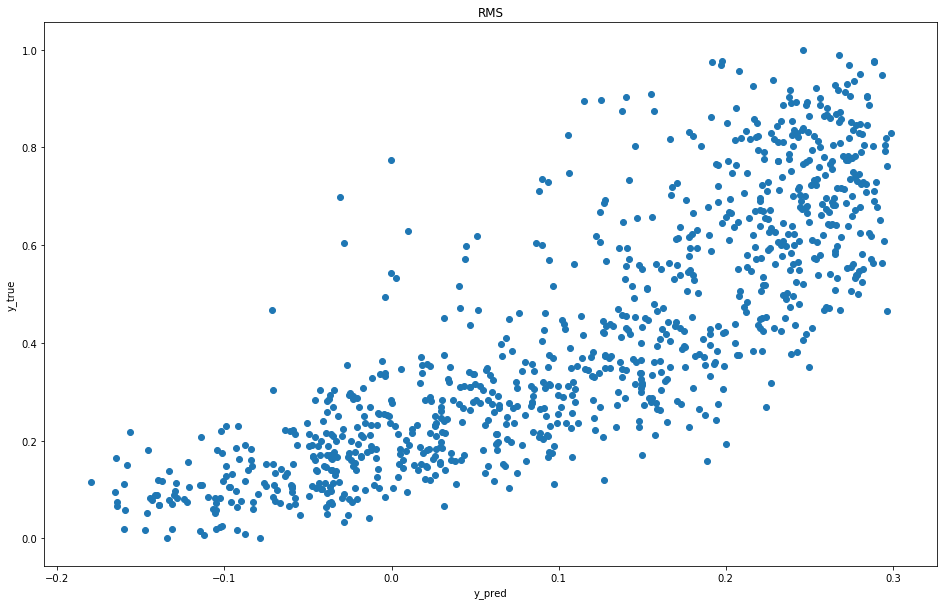

In [16]:
y_pred = net(Variable(torch.FloatTensor(datasets['test'].data[:,:IN_SIZE])))

fig = plt.figure(figsize=(16, 10))
plt.scatter(y_pred.data.numpy(), datasets['test'].data[:,IN_SIZE])
plt.xlabel('y_pred')
plt.ylabel('y_true')
plt.title('RMS')
plt.show()
plt.savefig(RES_DIR+'pred_true/RMS.png')